## Imports and read

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import nltk
import random
import gensim
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import *
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import describe
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
wine = pd.read_csv('./winemag-data-130k-v2.csv', index_col=0)

In [4]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


#### Exploratory analysis
Visualization 1

In [5]:
wine.isnull().sum(axis=0)

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

Looking for NA values, we see a lot of NA values. Especially for region and taster attributes. We can safely drop these as they should not affect the review.

In [6]:
wine.drop(columns=['region_1', 'region_2', 'taster_name', 'province',
                   'taster_twitter_handle', 'designation',
                  'title', 'winery'], inplace=True)

In [7]:
wine.columns

Index(['country', 'description', 'points', 'price', 'variety'], dtype='object')

These columns should explain the highest variance, others would cause only small increments in accuracy. Dropping all those will hurt accuracy, but not as much. Doing so reduces the number of parameters to estimate. 

/home/nischal/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nischal/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


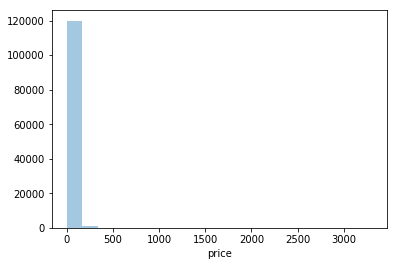

In [8]:
sns.distplot(wine.price, bins=20, kde=False)

prices have very high skew, using a log transformation

### Viz 1

/home/nischal/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


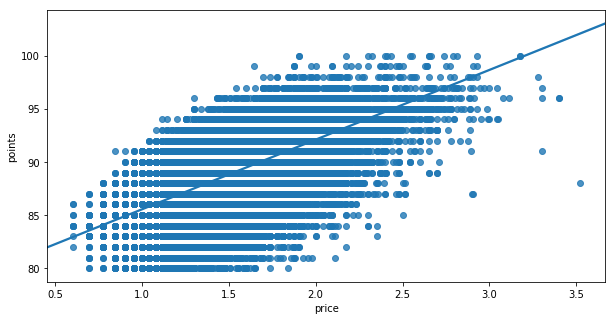

In [9]:
plt.figure(figsize = (10, 5))
sns.regplot(x = np.log10(wine.price), y = wine.points)

A good positive relation between price and points (looks like an expensive wine scores better)

For this visualization, I use a scatter plot with a line to show relation. 
Marks are points and line. Channels are position (both). (cite: lecture3-marks, slide 14)
Using points with position channel give is the best representative of quantitative data (cite: lecture5-tasks, slide 8)
The task here is to discover and identify trend between the two variables. This viz clearly shows the results of the task. 

### Viz 2

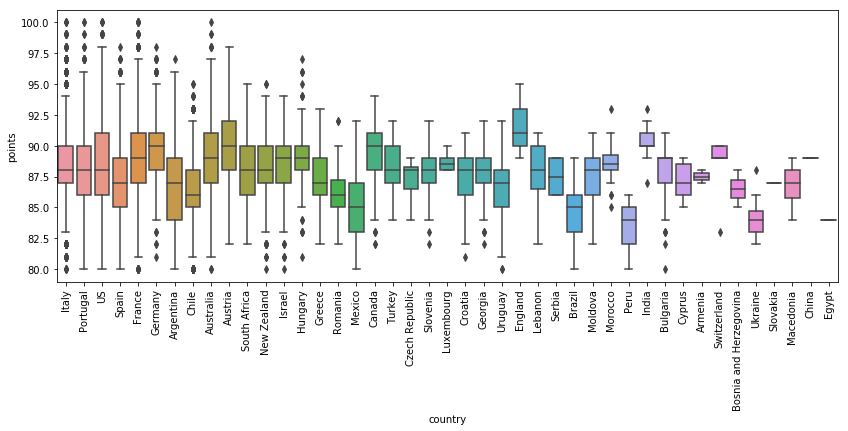

In [10]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=wine.country, y=wine.points)
plt.xticks(rotation=90)
plt.show()

Not a very good separation, but should help the model

For this viz, the task is discover. We would like to see if there is any separation beterrn the different contries for the points. Using a boxplot is most appropriate. Here, the marks are lines and points, and channels are position (for quantiles). I use no color palette (default seaborn colors).

## Data Preprocessing

### For train and test

In [11]:
## do for both train and test
dummy = pd.get_dummies(wine.loc[:, ['country', 'variety']])
wine_processed = wine.drop(['country', 'variety'], axis=1)
wine_processed = pd.concat([wine_processed, dummy], axis=1)

wine_processed.price.fillna(wine_processed.price.mean(), inplace=True)
wine_processed['price'] = np.log10(wine_processed.price)

In [12]:
## standard nltk functions for text preprocessing 

nltk.download('wordnet')
def tokenize_(text):
    tokens = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>3:
            _tokens = WordNetLemmatizer().lemmatize(token, pos = 'v')
            tokens.append(_tokens)
    return tokens

def tokenize(text_raw):
    tokens = []
    for i, line in enumerate(text_raw):
        tokens.append(tokenize_(line))
    return tokens

def get_dict(doc):
    return gensim.corpora.Dictionary(doc)

def generate_bow(doc_list):
    doc_dict = get_dict(doc_list)
    doc_bow = [doc_dict.doc2bow(line) for line in doc_list]
    return doc_bow, doc_dict

def run_lda(n_topics, doc_tfidf, doc_dict, verbose=False):
    doc_lda = gensim.models.LdaMulticore(doc_tfidf, num_topics = n_topics, id2word = doc_dict,
                                         passes = 3, minimum_probability=0.0)
    
    if verbose: 
        for i, t in doc_lda.print_topics(-1):
            print('Topic: {} Word: {} '.format(i,t))
        
    doc_topic_dist_tup = doc_lda.get_document_topics(doc_tfidf, minimum_probability=0.0)
    doc_topic_prob = np.zeros(shape= (len(doc_topic_dist_tup), n_topics), dtype = "float64")
    for i, top_dist in enumerate(doc_topic_dist_tup):
        doc_topic_prob[i,:] = np.asarray(top_dist)[:,1]
        
    return doc_lda, doc_topic_prob

[nltk_data] Downloading package wordnet to /home/nischal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
tokenized_desc = tokenize(wine_processed.description)
desc_bow, desc_dict = generate_bow(tokenized_desc)
tf = models.TfidfModel(desc_bow)
desc_tfidf = tf[desc_bow]

In [14]:
%%time
topics_data, topic_probs = run_lda(10, desc_tfidf, desc_dict)

CPU times: user 2min 4s, sys: 935 ms, total: 2min 5s
Wall time: 1min 45s


In [15]:
## covert to a dataframe and concat on original
topics = ['topic_' + str(i) for i in range(1, 11)]
topics_df = pd.DataFrame(topic_probs, columns=topics)
wine_processed.drop('description', axis=1, inplace=True)
wine_processed = pd.concat([wine_processed, topics_df], axis=1)

### Scaling only based on train

In [16]:
# split into train and test
train = wine_processed.sample(frac=0.8, random_state = 666)
test = wine_processed.drop(train.index)

In [17]:
def split(data):
    X = data.loc[:, data.columns != 'points']
    y = data.points
    return X, y.values.reshape(-1, 1)
    
train_X, train_y = split(train)
test_X, test_y = split(test)

In [18]:
ss = StandardScaler()
train_X['price'] = ss.fit_transform(train_X.price.values.reshape(-1, 1))
test_X['price'] = ss.transform(test_X.price.values.reshape(-1, 1))

/home/nischal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nischal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
train.shape, test.shape

((103977, 762), (25994, 762))

For preprocessing I take the following steps:
* Convert 'country' and 'variety' to dummy variables - this is done on the test and the train data together
* Convert 'description' to topic models using LDA. I do this to get the topic probabilities for a description, again on train and test together. First tokenize, remove stop words, and lematize (standard NLP tasks), then run LDA on the processed description
* Scale price (fit on train and transform on each separately)

We can see the final shapes of train and test. train has about 100k data points.

## Models

For this regression task, I will be using three linear regression techniques that are known to work well with high dimentions.
* Lasso - Lasso uses an L1 penalty, pushing less important features to 0, making estimation easier.
* Ridge - Ridge uses an L2 penalty, thus shrinking the coeffecients such as to give weights to each feature
* Elastic Net - Combines both L1 and L2 penalty to provide a much more generalized model.

For each of the models, I use cross-validation to find the optimal hyper parameters. I use 10 fold cv with r2 scoring. We use CV as it helps to generalize the hyper parameters across different samples of the data, helping better generalize the model.

### Lasso

In [20]:
from sklearn.linear_model import LassoCV, Lasso

In [97]:
lasso_cv = LassoCV(alphas=[1e-4, 1e-3, 1e-2], 
                   verbose=1, copy_X=True, cv=10, n_jobs=6)

In [98]:
%%time
cv_res = lasso_cv.fit(train_X, train_y.reshape(-1, ))

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
..............................[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   13.8s finished


CPU times: user 3min 12s, sys: 18.1 s, total: 3min 30s
Wall time: 44.8 s


In [99]:
cv_res.alpha_

0.0001

In [100]:
cv_res.score(test_X, test_y)

0.4183456723579287

### Ridge

In [21]:
from sklearn.linear_model import RidgeCV, Ridge

In [116]:
ridge_cv = RidgeCV(alphas=[1e-2, 1e-3, 5e-3], fit_intercept=False, scoring='r2', cv=10)

In [117]:
ridge_res = ridge_cv.fit(train_X, train_y.reshape(-1, ))

In [118]:
ridge_res.alpha_

0.001

In [120]:
ridge_res.score(test_X, test_y)

0.41719473573213584

### Elastic Net

In [22]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [23]:
el_cv = ElasticNetCV(l1_ratio= [.01, .1, .5, 1], fit_intercept=False, 
                    normalize=False, cv=10, copy_X=True, verbose=1)

In [24]:
el_cv.fit(train_X, train_y.reshape(-1, ))

/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=False,
       l1_ratio=[0.01, 0.1, 0.5, 1], max_iter=1000, n_alphas=100,
       n_jobs=None, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=1)

In [26]:
el_cv.alpha_

0.03709091433682448

In [27]:
el_cv.l1_ratio_

1.0

In [28]:
el_cv.score(test_X, test_y)

0.34835145923522415

### Comparing all three models

In [23]:
from sklearn.model_selection import KFold

In [26]:
%%time
lasso_opt = Lasso(alpha=1e-2, fit_intercept=False, normalize=False, copy_X=True)
ridge_opt = Ridge(alpha=1e-3, fit_intercept=False, normalize=False, copy_X=True)
el_opt = ElasticNet(alpha=0.0370, l1_ratio=1, fit_intercept=False, normalize=False, copy_X=True)

splits = 10
kf = KFold(n_splits=splits, shuffle=True, random_state=666)
scores = np.zeros(shape=(splits, 3))
for i, (train_idx, val_idx) in enumerate(kf.split(train_X)):
    train_fold_x, train_fold_y = train_X.iloc[train_idx, :], train_y[train_idx]
    test_fold_x, test_fold_y = train_X.iloc[val_idx, :], train_y[val_idx]
    
    print('split {0}'.format(i + 1))
    lasso_opt.fit(train_fold_x, train_fold_y)
    ridge_opt.fit(train_fold_x, train_fold_y)
    el_opt.fit(train_fold_x, train_fold_y)
    
    score = []
    score.append(lasso_opt.score(test_fold_x, test_fold_y))
    score.append(ridge_opt.score(test_fold_x, test_fold_y))
    score.append(el_opt.score(test_fold_x, test_fold_y))
    
    scores[i, :] = score

split 1
split 2
split 3
split 4
split 5
split 6
split 7
split 8
split 9
split 10
CPU times: user 12min 58s, sys: 17.9 s, total: 13min 15s
Wall time: 3min 21s


In [28]:
scores

array([[0.39782671, 0.41718905, 0.35582442],
       [0.40625044, 0.42156456, 0.36323444],
       [0.41226314, 0.43050713, 0.3732086 ],
       [0.40879616, 0.42583369, 0.36787995],
       [0.40739129, 0.42622916, 0.36650305],
       [0.43087693, 0.44675004, 0.38981585],
       [0.40518224, 0.42849212, 0.36064187],
       [0.40515676, 0.4187384 , 0.36746843],
       [0.41502065, 0.43267219, 0.37270166],
       [0.4188323 , 0.43449389, 0.37877082]])

In [29]:
scores.min(axis=0)

array([0.39782671, 0.41718905, 0.35582442])

Text(0, 0.5, 'R2 score')

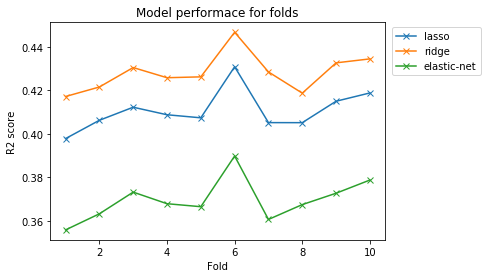

In [38]:
plt.plot(np.arange(1, 11), scores[:, 0], 'x-', label='lasso')
plt.plot(np.arange(1, 11), scores[:, 1], 'x-', label='ridge')
plt.plot(np.arange(1, 11), scores[:, 2], 'x-', label='elastic-net')
plt.legend(loc=1, bbox_to_anchor=(1.3, 1))
plt.title("Model performace for folds")
plt.xlabel("Fold")
plt.ylabel('R2 score')

### Predict with best model (Ridge)

In [36]:
ridge_opt.fit(train_X, train_y)
ridge_opt.score(test_X, test_y)

0.42728693752090396

Best model gives an R2 score of ~0.42. 

In [78]:
#cols = train_X.columns[
best = np.argsort(abs(ridge_opt.coef_[0]))[-20:][::-1]
best_labels = train_X.columns[best]
best_coef = ridge_opt.coef_[0][best]

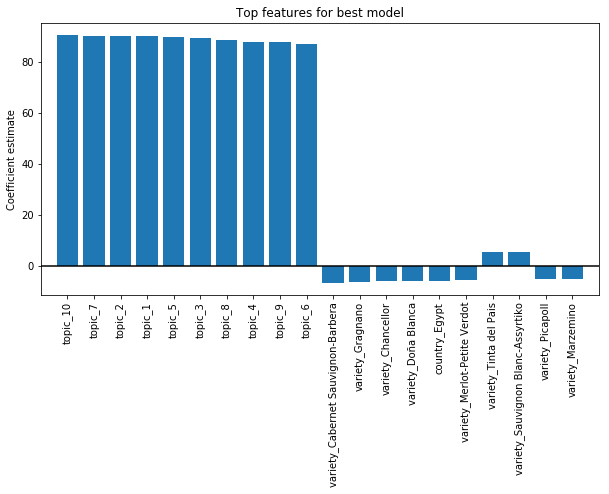

In [85]:
plt.figure(figsize=(10, 5))
plt.bar(x=best_labels, height=best_coef)
plt.xticks(rotation=90)
plt.hlines(y=0, xmin=-5, xmax=20)
plt.xlim(-1, 20)
plt.title("Top features for best model")
plt.ylabel("Coefficient estimate")
plt.show()

This viz shows the top features for Ridge, with the coefficients estimate. Here it is clear to see that the topic distribution of the description have the highest weights, much much higher than others. This shows that the model gives a lot of importance to the description. I do not annotate the heights as we do not want to compare the bars, just see the importance.

For this viz, the task is to summarize the results of ridge and present the top 20 features. I use a bar plot, where marks are lines (with fixed width) and channels are height. I use these as length is an effective communicator of quantitavtive data (coefficients).  